In [49]:
#Setup and Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [64]:
import numpy as np
import pandas as pd

In [65]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [66]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [67]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [68]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement  
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [24]:
# Analyze what columns exist in each table
inspector = inspect(engine)

#for loop to print each column name; using the get_columns method 

measurement_columns = inspector.get_columns('measurement')
print("Measurement")
for each_column in measurement_columns:
    print(each_column['name'], each_column["type"])
    
station_columns = inspector.get_columns('station')
print("\nStations")
for each_column in station_columns:
    print(each_column['name'], each_column["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
print(f"Last date is: {last_date[0]}")

# Calculate the date 1 year ago from the last data point in the database
last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Date from one year ago is: {last_year_date}")


Last date is: 2017-08-23
Date from one year ago is: 2016-08-23


In [30]:
# Perform a query to retrieve the data and precipitation scores
measurement_columns = (Measurement.date, Measurement.prcp)

precipitation_data = session.query(*measurement_columns).\
            filter(Measurement.date >= last_year_date).all()
precipitation_data[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [34]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
precipitation_df.head() 

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [35]:
# Set the index to the date column and sort the dataframe by date
precipitation_df.set_index('date',inplace=True)  #using the set_index method available to pandas 
precipitation_df = precipitation_df.sort_index()
precipitation_df  #view the dataframe

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


<bound method _AxesBase.grid of <AxesSubplot:title={'center':'Precipitation Levels Per Day Over the Past Year'}, xlabel='date', ylabel='Precipitation Level'>>

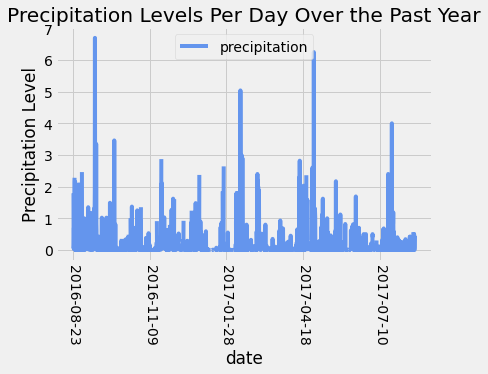

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data
axis = precipitation_df.plot(rot=-90, color='cornflowerblue')
axis.set_title("Precipitation Levels Per Day Over the Past Year")
axis.set_ylabel("Precipitation Level")
axis.grid  #enable gridlines

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [59]:
# Design a query to show how many stations are available in this dataset
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_by_station =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()   #.desc for descending order
count_by_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [61]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [62]:
# Choose the station with the highest number of temperature observations.
USC00519281_data =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > last_year_date).all()
USC00519281_data[:5]


[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

<AxesSubplot:ylabel='Frequency'>

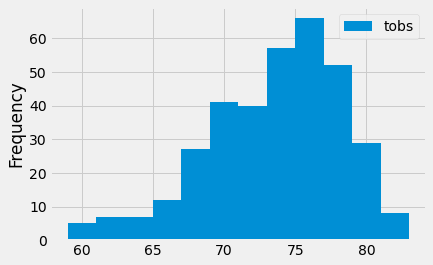

In [63]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_df= pd.DataFrame(USC00519281_data)
USC00519281_df.plot(kind="hist",bins=12)  #set bins=12 as found within the instructions

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
